# How do we fake a line?

First we are going to try simulating a line for a simple dataset. I had hoped to get to doing something similar for a PHA dataset but have run out of time.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sherpa.astro.ui import *

In [2]:
# Make this repeatable - when doing your analysis you would not do this!

np.random.seed(439742373)

In this notebook I am going to use the `simplex` (a.k.a. [neldermead](https://cxc.cfa.harvard.edu/sherpa/ahelp/neldermead.html)) optimizer and assume Poisson stats - in this case with the [cstat](https://cxc.cfa.harvard.edu/sherpa/ahelp/cstat.html) statistic as, as we'll seem most of the data points have values $\ll 20$.

In [3]:
set_stat('cstat')
set_method('simplex')

I am going to use an independent axis going from 3300 to 3800 in steps of 15:

In [4]:
dataspace1d(3300, 3800, step=15, dstype=Data1D)

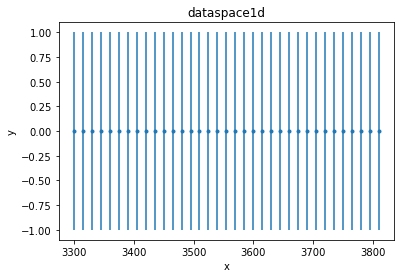

In [5]:
plot_data()

I am going to use the `const1d` model for the background and `gauss1d` to create a line:

In [6]:
set_source(const1d.bgnd + gauss1d.gline)

In [7]:
# randomly-adjusted parameter values to show something
bgnd.c0 = 5

gline.pos = 3500
gline.fwhm = 40
gline.ampl = 20

The [fake](https://cxc.cfa.harvard.edu/sherpa/ahelp/fake.html) command will create a randomly-realised data set from the model

In [8]:
fake()

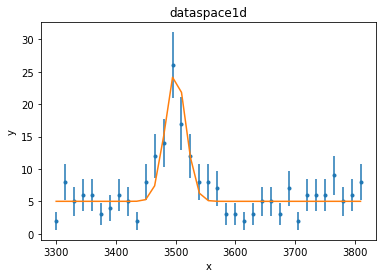

In [9]:
plot_data()
plot_model(overplot=True)

Given that we've just simulated the model it should describe the data well!

The simulated data can be displayed (we can see it is generated using Poisson noise so has generated integer values, which we need to be able to use the `cstat` statistic):

In [10]:
get_data().y

array([ 2.,  8.,  5.,  6.,  6.,  3.,  4.,  6.,  5.,  2.,  8., 12., 14.,
       26., 17., 12.,  8.,  8.,  7.,  3.,  3.,  2.,  3.,  5.,  5.,  3.,
        7.,  2.,  6.,  6.,  6.,  9.,  5.,  6.,  8.])

I am going to save this model as it is the "truth". I don't want to start fitting with these parameters as it would be a  very-biased starting point!

In [11]:
mdl_actual = get_source()
mdl_actual  # in a notebook we get a  nice display of the model

<BinaryOpModel model instance '(const1d.bgnd + gauss1d.gline)'>

To fit this dataset I create a new model expression. I am fortunate to know what model to use here...

In [12]:
set_source(const1d.bgnd1 + gauss1d.gline1)
mdl_fit = get_source()

mdl_fit

<BinaryOpModel model instance '(const1d.bgnd1 + gauss1d.gline1)'>

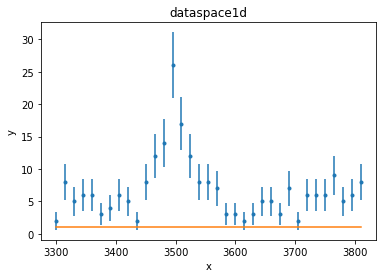

In [13]:
plot_fit()

So, the starting values are not particularly useful for this dataset. They are so far away that a fit is not guaranteed to get close to the minimum, so we can try using the [guess](https://cxc.cfa.harvard.edu/sherpa/ahelp/guess.html) function to improve the gaussian parameters:

In [14]:
guess(gline1)
print(gline1)

gauss1d.gline1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gline1.fwhm  thawed            4        0.004         4000           
   gline1.pos   thawed         3495         3300         3810           
   gline1.ampl  thawed           26        0.026        26000           


Unfortunately in CIAO 4.13 the guess routine for the FWHM parameter is too-simplistic. It will be better in CIAO 4.14 and I am going to use the FWHM from that code (although we may improve it more).

In [15]:
gline1.fwhm = 60

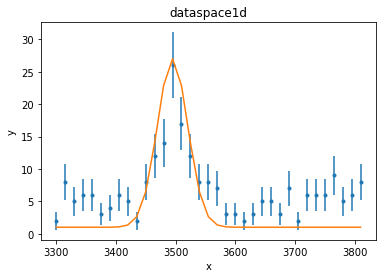

In [16]:
plot_fit()

That looks a lot better, so we should get a "good" fit:

In [17]:
fit()

Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 241.695
Final fit statistic   = 26.0163 at function evaluation 377
Data points           = 35
Degrees of freedom    = 31
Probability [Q-value] = 0.720541
Reduced statistic     = 0.839236
Change in statistic   = 215.678
   bgnd1.c0       5.00387     
   gline1.fwhm    54.0168     
   gline1.pos     3497.45     
   gline1.ampl    16.3997     


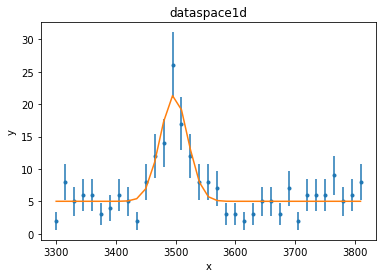

In [18]:
plot_fit()

We can check errors with [covar](https://cxc.cfa.harvard.edu/sherpa/ahelp/covar.html) and [conf](https://cxc.cfa.harvard.edu/sherpa/ahelp/covar.html) (`covar` is faster but often generates smaller errors).

In [19]:
covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cstat
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   bgnd1.c0          5.00387    -0.440636     0.440636
   gline1.fwhm       54.0168     -10.2732      10.2732
   gline1.pos        3497.45     -4.45621      4.45621
   gline1.ampl       16.3997     -3.23402      3.23402


In [20]:
conf()

gline1.fwhm lower bound:	-9.50448
bgnd1.c0 lower bound:	-0.429798
gline1.ampl lower bound:	-2.99894
gline1.pos lower bound:	-4.354
bgnd1.c0 upper bound:	0.45154
gline1.ampl upper bound:	3.48853
gline1.fwhm upper bound:	11.1472
gline1.pos upper bound:	4.613
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   bgnd1.c0          5.00387    -0.429798      0.45154
   gline1.fwhm       54.0168     -9.50448      11.1472
   gline1.pos        3497.45       -4.354        4.613
   gline1.ampl       16.3997     -2.99894      3.48853


We can view the search surface a number of ways:

- [int_proj](https://cxc.cfa.harvard.edu/sherpa/ahelp/int_proj.html) varies one parameter
- [reg_proj](https://cxc.cfa.harvard.edu/sherpa/ahelp/reg_proj.html) varies two parameters

What we like to see is nice parabolic surfaces and the best-fit at the minimum.

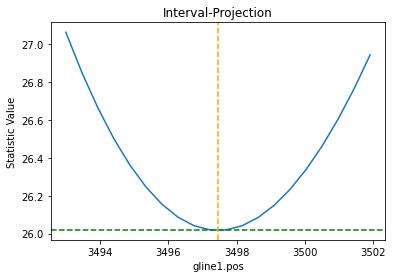

In [21]:
int_proj(gline1.pos)

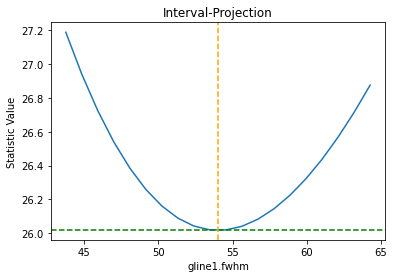

In [22]:
int_proj(gline1.fwhm)

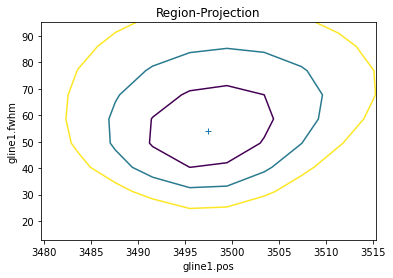

In [23]:
reg_proj(gline1.pos, gline1.fwhm)

These routines guess what ranges to use for the parameter values, but you can be explicit:

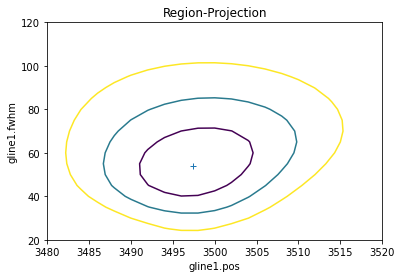

In [24]:
reg_proj(gline1.pos, gline1.fwhm, min=[3480, 20], max=[3520, 120], nloop=[21, 21])

There's a few things we might care to track, in particular the best-fit statistic:

In [25]:
calc_stat()

26.016327776170872

The [get_stat_info](https://cxc.cfa.harvard.edu/sherpa/ahelp/get_stat_info.html) function returns information on each dataset (in this case there's only one):

In [26]:
statinfo = get_stat_info()
statinfo[0]  # another object that displays nicely in Jupyter notebooks

<Statistic information results instance>

In [27]:
print(statinfo[0])

name      = Dataset [1]
ids       = [1]
bkg_ids   = None
statname  = cstat
statval   = 26.016327776170872
numpoints = 35
dof       = 31
qval      = 0.7205412456294387
rstat     = 0.8392363798764797


# Can we "script this"?

There's a number of ways we could simulate and fit the data, so the following is **an example** and should not be used directly for research.

What we want to do is repeat the followung

- simulate the data
- fit the data (from a "known" starting point, where the definition of "known" depends on what you want to do)
- get the fit statistic and best-fit parameter values

In [28]:
import logging

def mysim(niter=1):
    """Simulate the bgnd + line model niter times
    
    Note that there is no attempt to handle fits that fail.

    This is also not a well-written function (it uses plenty of global
    variables) but writing a better one would help hide the simulation details.
    """

    # Hide the screen output. Note that in CIAO 4.14 this will be
    # much easier with sherpa.utils.SherpaVerbosity thanks to Moritz
    #
    logger = logging.getLogger('sherpa')
    lvl = logger.getEffectiveLevel()
    logger.setLevel(logging.ERROR)

    # For each iteration we store the best-fit statistic and the best-fit values
    stats = []
    
    for i in range(niter):

        # The "truth"
        set_source(mdl_actual)
        
        # Fake up a data set
        fake()

        # Now the model we are fitting
        set_source(mdl_fit)
        
        # Reset the values to their "starting" value and then
        # guess the line. I would prefer to create new models for
        # each iteration, so we are sure, but this is a lot easier.
        #
        mdl_fit.reset()
        guess(gline1)
        
        # do the fit
        fit()
        statinfo = get_stat_info()
        
        # store the data we want
        #
        store = [statinfo[0].statval]
        store.extend(mdl_fit.thawedpars)
        stats.append(store)
        
    # Restore the screen output
    logger.setLevel(lvl)
    
    return np.asarray(stats)

Let's get an idea for how quickly (or slowly) it runs:

In [29]:
%time stats = mysim(100)

CPU times: user 5.23 s, sys: 0 ns, total: 5.23 s
Wall time: 5.22 s


In [30]:
%time stats = mysim(1000)

CPU times: user 54.9 s, sys: 17.1 ms, total: 54.9 s
Wall time: 54.9 s


In [31]:
stats.shape

(1000, 5)

In [32]:
stats[0]

array([  27.17377524,    5.84279762,   44.53580849, 3499.41947883,
         15.34652663])

Sherpa has a few functions for plotting this sort of data, including

- [plot_trace](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_trace.html)
- [plot_cdf](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_cdf.html)
- [plot_pdf](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_pdf.html)
- [plot_scatter](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_scatter.html)

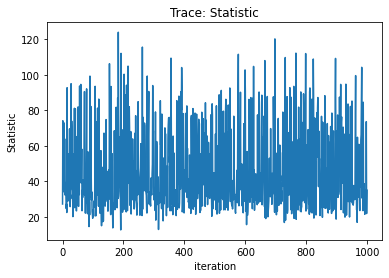

In [33]:
plot_trace(stats[:, 0], name='Statistic')

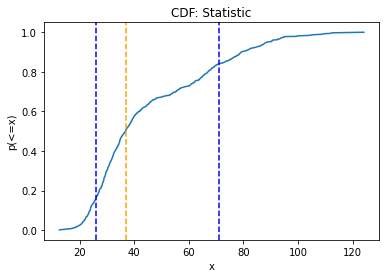

In [34]:
plot_cdf(stats[:, 0], name='Statistic')

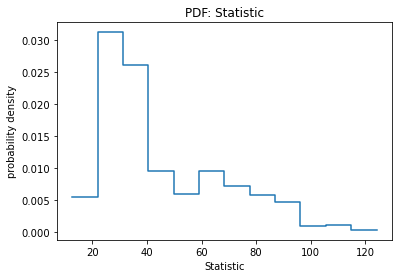

In [35]:
plot_pdf(stats[:, 0], name='Statistic', xlabel='Statistic')

I sometimes forget what the order of the parameters are, so we can ask Sherpa in a number of ways. Here's my geeky version:

In [36]:
[p.fullname for p in mdl_fit.pars if not p.frozen]

['bgnd1.c0', 'gline1.fwhm', 'gline1.pos', 'gline1.ampl']

We can also use `matplotlib` routines, such as this scatter plot of the position and FWHM values color-coded by the statistic. I could have ued `plot_scatter` but then wouldn't have had the color-coding.

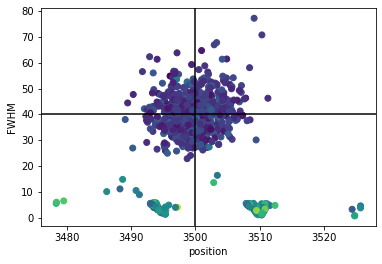

In [37]:
plt.scatter(stats[:, 3], stats[:, 2], c=stats[:, 0])

plt.xlabel('position')
plt.ylabel('FWHM')

plt.axvline(gline.pos.val, c='k')
plt.axhline(gline.fwhm.val, c='k');

It's always interesting to see these little pockets of search space which aren't a good fit, but are good enough to trap your optimizer of choice!

# Varying parameter values

The above just takes a single model, with fixed parameters, and simulates from that. I wanted to talk about varying the parameters at each simulation but unfortunately we don't have code that integrates seamlessly with the `sherpa.astro.ui` model. We have to go somewhat off-piste (and is something we Sherpa developers should think about improving).

So, at this point `mdl_fit` is set to the best-fit parameters of the last sample:

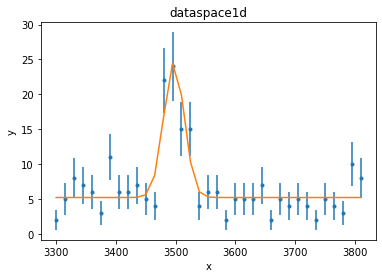

In [38]:
plot_fit()

In [39]:
mdl_fit

<BinaryOpModel model instance '(const1d.bgnd1 + gauss1d.gline1)'>

I am going to **cheat** for the purposes of this notebook and use this particular dataset as the data + fit I am trying to check. In reality you should (probably) use a real dataset as this one has **no** systematic errors in (such as the wrong model or un-modelled signal).

What I want is the covariance matrix, which we can get with [covar](https://cxc.cfa.harvard.edu/sherpa/ahelp/covar.html):

In [40]:
covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cstat
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   bgnd1.c0          5.22959      -0.4229       0.4229
   gline1.fwhm       39.9206     -6.17221      6.17221
   gline1.pos        3497.31     -3.25806      3.25806
   gline1.ampl       19.4018     -3.85596      3.85596


In [41]:
cres = get_covar_results()
cres  # use fancy output in a notebook to display

Parameter,Best-fit value,Lower Bound,Upper Bound
bgnd1.c0,5.22959,-0.4229,0.4229
gline1.fwhm,39.9206,-6.17221,6.17221
gline1.pos,3497.31,-3.25806,3.25806
gline1.ampl,19.4018,-3.85596,3.85596


The covariance matrix is stored in the cunnningly-named `extra_output` field:

In [42]:
cmat = cres.extra_output
print(cmat)

[[  0.17884478  -0.4558942   -0.09026848  -0.14192661]
 [ -0.4558942   38.09614498   3.83540481 -12.88918489]
 [ -0.09026848   3.83540481  10.6149865   -0.74914956]
 [ -0.14192661 -12.88918489  -0.74914956  14.86839107]]


The standard one-sigma errors are the square root of the diagonal: 

In [43]:
errors = np.sqrt(cmat.diagonal())
print(errors)

[0.42290044 6.17220746 3.25806484 3.85595527]


We also want the current best-fit values:

In [44]:
parvals = cres.parvals
print(parvals)

(5.229588729417014, 39.920639478779194, 3497.309083387116, 19.401843818281506)


The reason for doing this is that there are some low-level routines in the [sherpa.sim.sample](https://sherpa.readthedocs.io/en/latest/mcmc/sample.html) module - in particular

- [NormalParameterSampleFromScaleMatrix](https://sherpa.readthedocs.io/en/latest/mcmc/api/sherpa.sim.sample.NormalParameterSampleFromScaleMatrix.html)

- [NormalParameterSampleFromScaleVector](https://sherpa.readthedocs.io/en/latest/mcmc/api/sherpa.sim.sample.NormalParameterSampleFromScaleVector.html)

that can help, but you need a `Fit` object (which I could get you but it would make this even-more confusing). What I am gonig to do is replicat some of this functionality.

The [NumPy random module](https://numpy.org/doc/stable/reference/random/index.html) has switched over from a single global state to a more-OO approach. As I need to understand this I'm going to try it out here.

In [45]:
rng = np.random.default_rng(9876543) # this is a highly-secret value

In [46]:
def mksamples_uncorrelated(niter):
    """Create niter samples of the thawed parameters: uncorrelated"""
    samples = np.zeros((niter, len(parvals)))
    for i in range(niter):
        samples[i] = rng.normal(parvals, errors)
        
    return samples

def mksamples_correlated(niter):
    """Create niter samples of the thawed parameters: correlated"""
    return rng.multivariate_normal(parvals, cmat, niter)

These two routines use the error values we've just calculated with `covar` to create `niter` samples of the thawed parameters:

In [47]:
usamples = mksamples_uncorrelated(1000)
csamples = mksamples_correlated(1000)

These return a niter by number-of-free-parameters, so each row matches

    ['bgnd1.c0', 'gline1.fwhm', 'gline1.pos', 'gline1.ampl']

Therefore `usamples[:, 1]` is fwhm and `csamples[:, 2]` is ampl.

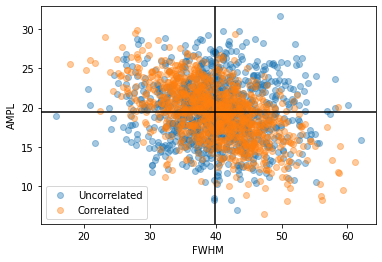

In [48]:
plt.scatter(usamples[:, 1], usamples[:, 3], alpha=0.4, label='Uncorrelated')
plt.scatter(csamples[:, 1], csamples[:, 3], alpha=0.4, label='Correlated')

plt.xlabel('FWHM')
plt.ylabel('AMPL')

plt.axvline(parvals[1], c='k')
plt.axhline(parvals[3], c='k')

plt.legend();

I chose this pair as they are likely to be correlated.

The Python [corner](https://corner.readthedocs.io/en/stable/) package is really useful for viewing datasets like this. You can

    pip install corner
    
to install this (I forget the details of whether this is safe to do within a notebook but "it works for me today").

In [49]:
!pip install corner

In [50]:
import corner

In [51]:
pnames = [p.name for p in get_source().pars if not p.frozen]

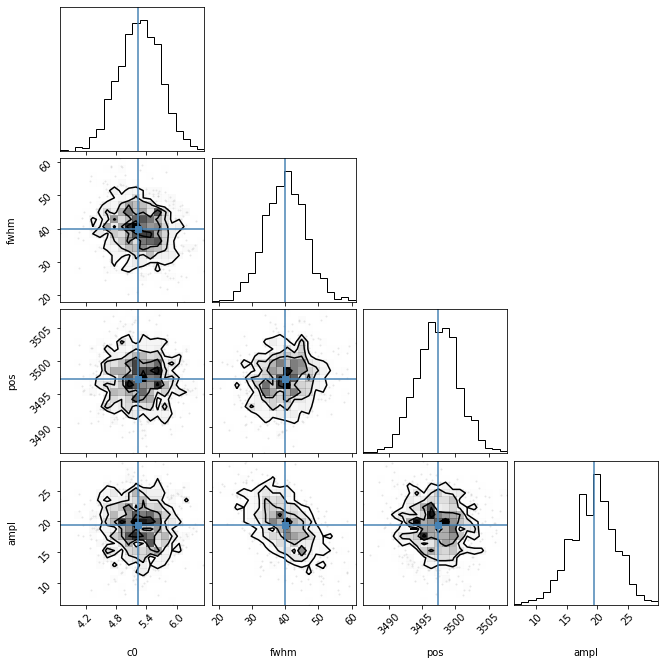

In [52]:
# This is the uncorrelated case
corner.corner(csamples, labels=pnames, truths=parvals);

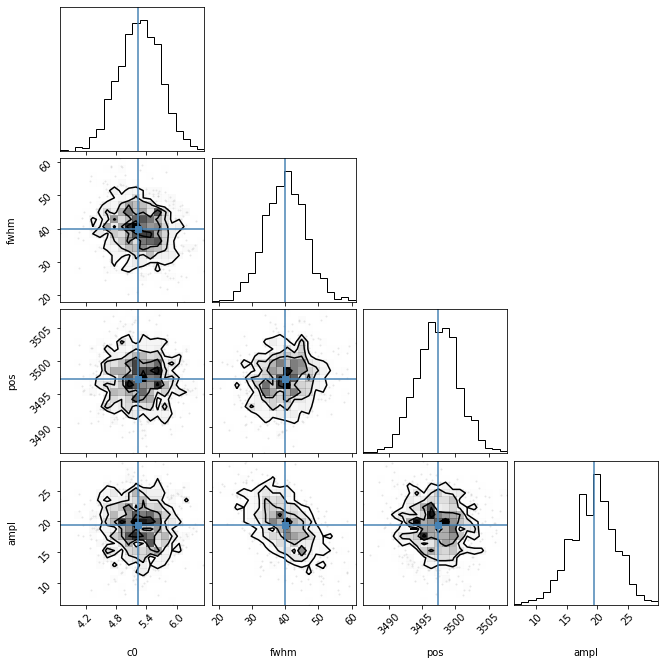

In [53]:
# This is the correlated case
corner.corner(csamples, labels=pnames, truths=parvals);

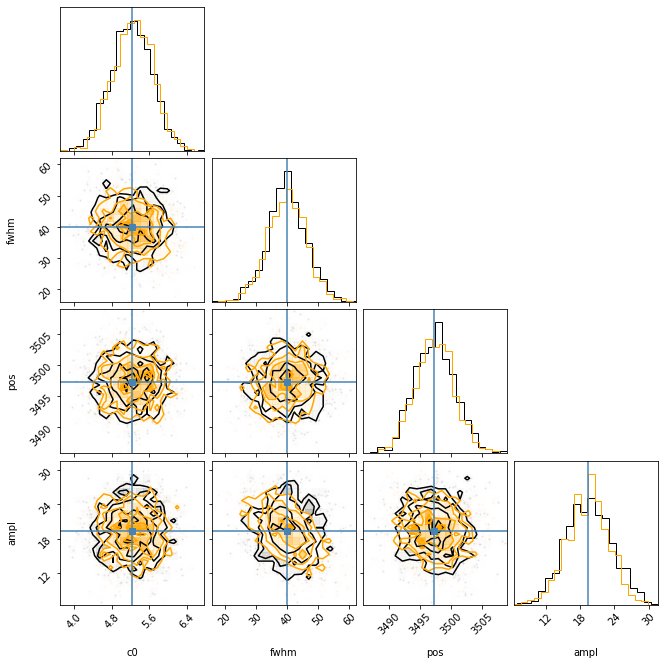

In [54]:
# and here we overplot them, just because we can
fig = corner.corner(usamples, labels=pnames, truths=parvals)
corner.corner(csamples, color='orange', fig=fig);

We can use these samples in our simulation, with something like the following function.

**NOTE** as already mentioned, I am **cheating** here as I am using a fit to a simulation to determine the errors on the parameters. I really should be using a fit to an actual data set to determine the samples. 

In [55]:
def mysim2(samples):
    """Simulate the bgnd + line model using the samples array
    
    Note that there is no attempt to handle fits that fail.
    
    """

    # This is not well-designed code as it relies on global variables
    # like mdl_fit and gline1. If you are interested in how you can improve
    # stuff like this than I can be contacted directly.
    #
    
    # Check that samples is 2D and has the correct size.
    #
    # Note that there is no guarantee that you've got the parameters
    # in the right order with this API.
    #
    niter, nfree = samples.shape
    if nfree != len(mdl_actual.thawedpars):
        raise ValueError(f"Expected {len(mdl1.thawedpars)} thawed pars but sent {nfree}")
        
    # Store the pair (best-fit statistic, reduced chi-square)
    # although as the same number of points are being used we
    # know reduced chi-square = best-fit statistic / 30 here.
    #
    stats = []

    # Hide the screen output. Note that in CIAO 4.14 this will be
    # much easier with sherpa.utils.SherpaVerbosity
    #
    logger = logging.getLogger('sherpa')
    lvl = logger.getEffectiveLevel()
    logger.setLevel(logging.ERROR)

    orig_params = mdl_actual.thawedpars
    
    for i in range(niter):
        # The "truth", but this time we tweak the parameter values 
        set_source(mdl_actual)
        mdl_actual.thawedpars = samples[i]
        fake()

        # Now the model we are fitting
        set_source(mdl_fit)
        
        # Reset the values to their "starting" value and then
        # guess the line. I would prefer to create new models for
        # each iteration, so we are sure, but this is a lot easier.
        #
        mdl_fit.reset()
        guess(gline1)
        
        # do the fit
        fit()
        statinfo = get_stat_info()
        
        # store the data we want
        #
        store = [statinfo[0].statval]
        store.extend(mdl_fit.thawedpars)
        stats.append(store)
        
    # Restore the screen output
    logger.setLevel(lvl)
    
    # Restore the model parameters for mdl
    mdl_actual.thawedpars = orig_params
    
    return np.asarray(stats)

In [56]:
%time uncorrelated = mysim2(usamples)

CPU times: user 58.9 s, sys: 35.6 ms, total: 59 s
Wall time: 58.9 s


In [57]:
%time correlated = mysim2(csamples)

CPU times: user 1min, sys: 39.9 ms, total: 1min
Wall time: 1min


We can compare these to the `stats` output of `mysim`. I am going to use `corner` again but note that these arrays have an extra column (the first one) which is the statistic:

In [58]:
labelnames = ['statistic'] + pnames
labelvals = [None] + list(parvals)

First we can look at the runs individually:

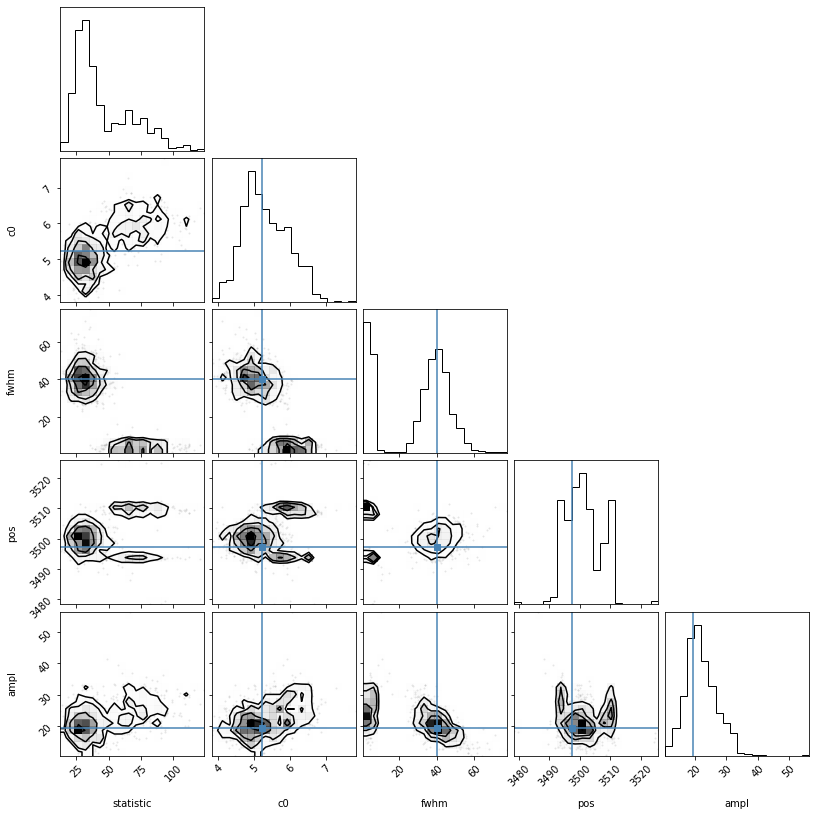

In [59]:
corner.corner(stats, labels=labelnames, truths=labelvals);

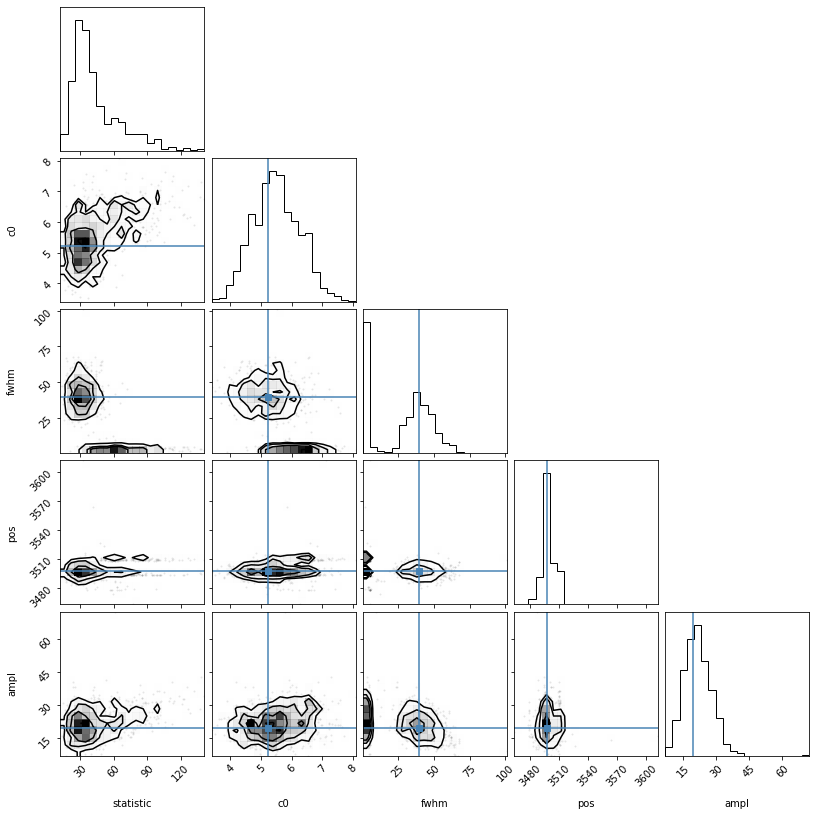

In [60]:
corner.corner(uncorrelated, labels=labelnames, truths=labelvals);

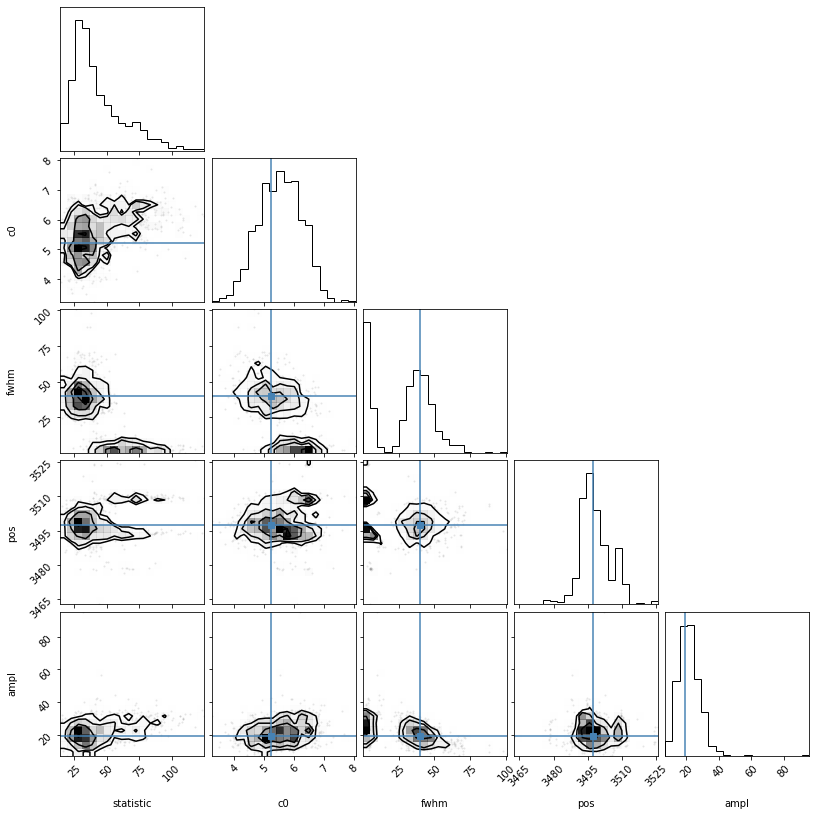

In [61]:
corner.corner(correlated, labels=labelnames, truths=labelvals);

We can try over-plotting the `correlated` data onto the original run: 

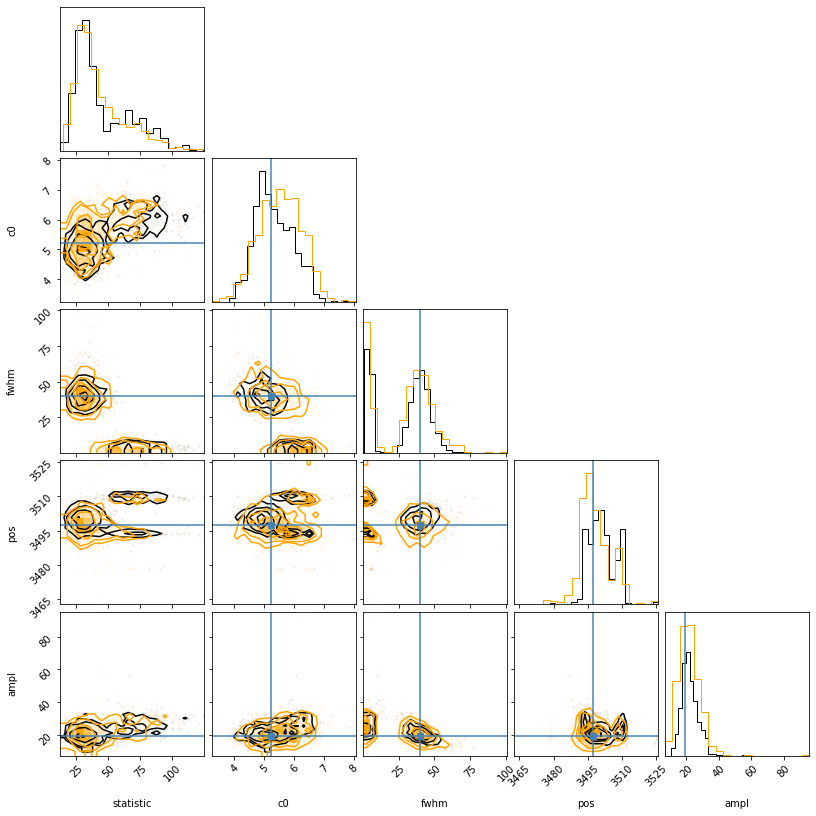

In [62]:
fig = corner.corner(stats, labels=labelnames, truths=labelvals);
corner.corner(correlated, color='orange', fig=fig);

There's some potentially-interesting shifts, but we've run out of time.

One thing I have not shown is how sensitive this particular approach is to getting a bad "dataset" [$^\dagger$]; in this case we may not get a positive-definite covariance matrix whihc would mean no way to run `mksamples_uncorrelated` or `mksamples_correlated`. In situations like this you may want to leverage MCMC routines - whether it's Sherpa's [get_draws](https://cxc.harvard.edu/sherpa/ahelp/get_draws.html), which is designed for Poisson statistics, or one of the many other MCMC packages.

We can also think about using [plot_pvalue](https://cxc.harvard.edu/sherpa/ahelp/plot_pvalue.html) to look at how supported a model component is by the data, but that's a different notebook.

---

[$^\dagger$] there is no-such thing as a bad dataset, it's just that not all datasets want to come out and play